In [3]:
import sys
import os
SFCN_path = "../UKBiobank_deep_pretrain-master"
sys.path.append(SFCN_path)
Data_path = "../data_small/preprocessed"
Info_path =  "../data_small/clinical_data.csv"

In [4]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from scipy.linalg import lstsq

ModuleNotFoundError: No module named 'h5py'

# Load the model
Use preprocessed brain scans (**??**)    
**Model input shape: [batch_size, 1, 160, 192, 160]**

In [6]:
retrain = False
state_dict_path = "./trained_SFCN/UKBB_HC/UKBB_HC_best.pth"

model = SFCN()
model = torch.nn.DataParallel(model)

if not retrain:
    fp_ = os.path.join(SFCN_path, './brain_age/run_20190719_00_epoch_best_mae.p')
    model.load_state_dict(torch.load(fp_))
else:
    state_dict = torch.load(state_dict_path) 
    model.load_state_dict(state_dict['model'])

model.cuda()

DataParallel(
  (module): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, 

# Get bin-ceter
np array of shape (40,)

In [7]:
## a one-year age interval between 42 to 82 (for UK Biobank)
bc_1 = np.arange(start=42.5, stop=82, step=1)
## a two-year age interval between 14 to 94 (for PAC 2019).
bc_2 = np.arange(start=15.0, stop=94, step=2)

# Try with one pre-processed sample

According to the SFCN paper: "40 digits that represent the predicted probability that the subject’s age falls into a one-year age interval between 42 to 82 (for UK Biobank)".
- ?? The data we are using now contains age that is out of range
- ?? Does the UKB data we are going to use later all falls in this age range?

In [54]:
# single test sample path
## second arg of path.join cannot start by "/" or "\"
test_sample_path = os.path.join(Data_path, "AOMIC/ds002785/sub-0001/sub-0001_T1w.h5")
print(test_sample_path)

../data_small/preprocessed\AOMIC/ds002785/sub-0001/sub-0001_T1w.h5


## Get chronologicalage and bin-center

In [32]:
## ??? fixed bin range, how about ages out of range
## label and y do not matter here, just to get the bin-center: bc

## true age for this subject is 26.25, which is output range
test_ture_age = 26.25 ## should be retrieved from file
label = np.array([71.3,]) # Assuming the subject is 71.3-year-old.

# Transforming the age to soft label (probability distribution)
bin_range = [42,82]
bin_step = 1
sigma = 1

## get a normal distribution centered at the label
## y: porb within each bin; bc: bin-center
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma) 
y = torch.tensor(y, dtype=torch.float32) ## torch.Size([1, 40])

#print(bc) ## [42.5, ..., 81.5] ## np array (40,)

## Load data

In [55]:
test_h5 = h5py.File(test_sample_path, 'r')
test_arr = np.array(test_h5['preprocessed_volume']) ## size: (160, 192, 160)

In [56]:
test_arr

array([[[-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        ...,
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448]],

       [[-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        [-0.49228448, -0.49228448, -0.49228448, ..., -0.49228448,
         -0.49228448, -0.49228448],
        ...,
        [-0.49228448, -0.49228448, -0.49228448, ..., -

**??? no need preprocess here**:
divide by mean, or, dpu.crop_center

In [59]:
sp = (1,1) + test_arr.shape
test_reshape = test_arr.reshape(sp)
test_input = torch.tensor(test_reshape, dtype=torch.float32).cuda() ## torch.Size([1, 1, 160, 192, 160])

## Inference brain age

In [60]:
# Evaluation
model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    ## list of length 1 (because only one data?), 
    ## each list element is a tensor of size [1, 40, 1, 1, 1] -- prob distribution?
    t_output = model(test_input) 

In [62]:
# Result of the first (only one) sample
test_output = t_output[0].cpu().reshape([1, -1]) ## torch.Size([1, 40]), prob distribution in log domain

In [63]:
test_output_arr = test_output.numpy().reshape(-1) ## np array (40,)

In [64]:
test_prob = np.exp(test_output_arr) ## exp
test_pred = test_prob @ bc
print("predicted age: \t {}".format(test_pred))
print("ture age: \t {}".format(test_ture_age))

predicted age: 	 62.145415740145836
ture age: 	 26.25


In [65]:
test_prob @ bc2

54.290834161336534

# Run on the small dataset

## Search for all the data path

In [11]:
# Get file path list

#file_id = 0
file_path_list = []

for (dirpath, dirnames, filenames) in os.walk(Data_path):
    #file_id += 1
    #print(dirpath)
    #print(dirnames)
    #print(filenames)
    #print("------------")
    if len(filenames) > 0:
        if len(filenames) > 1:
            print("! error: Multiple samples in a dir.")
        filepath = os.path.join(dirpath, filenames[0])
        print(filepath)
        file_path_list.append(filepath)

print("========================")
print("There're {} samples in total.".format(len(file_path_list)))

../data_small/preprocessed\AOMIC\ds002785\sub-0001\sub-0001_T1w.h5
../data_small/preprocessed\AOMIC\ds002785\sub-0002\sub-0002_T1w.h5
../data_small/preprocessed\AOMIC\ds002785\sub-0003\sub-0003_T1w.h5
../data_small/preprocessed\AOMIC\ds002785\sub-0004\sub-0004_T1w.h5
../data_small/preprocessed\AOMIC\ds002785\sub-0005\sub-0005_T1w.h5
../data_small/preprocessed\AOMIC\ds002790\sub-0001\sub-0001_T1w.h5
../data_small/preprocessed\AOMIC\ds002790\sub-0002\sub-0002_T1w.h5
../data_small/preprocessed\AOMIC\ds002790\sub-0003\sub-0003_T1w.h5
../data_small/preprocessed\AOMIC\ds002790\sub-0004\sub-0004_T1w.h5
../data_small/preprocessed\AOMIC\ds002790\sub-0005\sub-0005_T1w.h5
../data_small/preprocessed\AOMIC\ds003097\sub-0001\sub-0001_T1w.h5
../data_small/preprocessed\AOMIC\ds003097\sub-0002\sub-0002_T1w.h5
../data_small/preprocessed\AOMIC\ds003097\sub-0003\sub-0003_T1w.h5
../data_small/preprocessed\AOMIC\ds003097\sub-0004\sub-0004_T1w.h5
../data_small/preprocessed\AOMIC\ds003097\sub-0005\sub-0005_T1

In [12]:
my_info_df0 = pd.DataFrame(file_path_list, columns = ["path"])
my_info_df0.head()

,path
0,../data_small/preprocessed\AOMIC\ds002785\sub-...
1,../data_small/preprocessed\AOMIC\ds002785\sub-...
2,../data_small/preprocessed\AOMIC\ds002785\sub-...
3,../data_small/preprocessed\AOMIC\ds002785\sub-...
4,../data_small/preprocessed\AOMIC\ds002785\sub-...


## Read in the clinical information about the data

In [13]:
info_df = pd.read_csv(Info_path)

In [14]:
info_df

,study,participant_id,sex,age,status
0,ABIDE_I/CMU_a,sub-0050642,0.0,33.00,ASD
1,ABIDE_I/CMU_a,sub-0050646,0.0,21.00,ASD
2,ABIDE_I/CMU_a,sub-0050647,0.0,27.00,ASD
3,ABIDE_I/CMU_a,sub-0050649,0.0,22.00,ASD
4,ABIDE_I/CMU_a,sub-0050653,0.0,30.00,ASD
...,...,...,...,...,...
11168,STRADL,ST1GDU2661,1.0,57.28,MDD
11169,STRADL,ST1GDU2663,1.0,69.12,MDD
11170,STRADL,ST1GDU2664,0.0,37.08,HC
11171,STRADL,ST1GDU2665,1.0,51.37,MDD


## Extract corresponding key column content from data path

In [15]:
## This part needs to be changed if file tree changes in the UKB data

def extract_study_id_from_relative_path(path):
    """
    Input example: ../data_small/preprocessed\AOMIC\ds002785\sub-0001\sub-0001_T1w.h5
                or ../data_small/preprocessed\ds000119\sub-01\sub-01_T1w.h5
    Return study and participant_id to query the clinical_data table
    """
    path = path.replace(Data_path, '')
    path_content = path.split("\\")  ## list
    if len(path_content) == 5:
        participant_id = path_content[3]
        study = path_content[1] + "/" + path_content[2]
    elif len(path_content) == 4:
        participant_id = path_content[2]
        study = path_content[1]
    else:
        print("! error: cannot find corresponding 'study' and 'participant_id'.")
    return study, participant_id

extract_study_id_from_relative_path(file_path_list[0])

('AOMIC/ds002785', 'sub-0001')

In [16]:
def assign_study_id_to_df(row):
    """
    each row, take in the path, 
    extract info on study and participant id
    assign to corrsponding columns
    """
    study_id = extract_study_id_from_relative_path(row["path"])
    row["study"] = study_id[0]
    row["participant_id"] = study_id[1]
    return row

In [17]:
my_info_df1 = my_info_df0.apply(assign_study_id_to_df, axis=1)
my_info_df1.head()

,path,study,participant_id
0,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0001
1,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0002
2,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0003
3,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0004
4,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0005


## Match data with clinical info

In [18]:
# perform inner-join
my_info_df2 = my_info_df1.merge(info_df, on=["study", "participant_id"])

In [19]:
my_info_df2

,path,study,participant_id,sex,age,status
0,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0001,1.0,26.2500,HC
1,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0002,1.0,21.0000,HC
2,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0003,0.0,23.0000,HC
3,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0004,1.0,23.5000,HC
4,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0005,0.0,21.7500,HC
5,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0001,0.0,25.5000,HC
6,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0002,1.0,23.2500,HC
7,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0003,1.0,25.0000,HC
8,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0004,1.0,20.0000,HC
9,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0005,0.0,24.7500,HC


In [6]:
# save the dataframe so that we can load it directly next time
#my_info_df2.to_pickle("./df_info_path_data_small.pkl")
my_info_df2 = pd.read_pickle("./df_info_path_data_small.pkl")

## Create a large dataset of 3-D brain scan arrays
?? too much data may not fit into the memory

### Find the np array of each sample

In [21]:
def extract_np_array_from_h5(h5_path):
    """
    Input: one .h5 path of a preprocessed sample
    Return: np array of the .h5 file
    """
    img_h5 = h5py.File(h5_path, 'r')
    img_arr = np.array(img_h5['preprocessed_volume']) ## size: (160, 192, 160)
    return img_arr

extract_np_array_from_h5(my_info_df2["path"][0]).shape

(160, 192, 160)

In [22]:
def assign_data_array_to_df(row):
    """
    for each row in a dataframe, based on the "path" column, 
    form the np array of size (1, 160, 192, 160) of the brain scan, assign it to the "image" volumn
    return the new row
    """
    img_arr = extract_np_array_from_h5(row["path"])
    sp = (1,) + img_arr.shape
    img_arr_reshape= img_arr.reshape(sp)  ## size: (1, 160, 192, 160)
    row["image"] = img_arr_reshape
    return row

In [23]:
my_info_df3 = my_info_df2.apply(assign_data_array_to_df, axis=1)
my_info_df3.head()

,path,study,participant_id,sex,age,status,image
0,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0001,1.0,26.25,HC,[[[[-0.49228448 -0.49228448 -0.49228448 -0.492...
1,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0002,1.0,21.00,HC,[[[[-0.51895345 -0.51895345 -0.51895345 -0.518...
2,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0003,0.0,23.00,HC,[[[[-0.52216812 -0.52216812 -0.52216812 -0.522...
3,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0004,1.0,23.50,HC,[[[[-0.52262488 -0.52262488 -0.52262488 -0.522...
4,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0005,0.0,21.75,HC,[[[[-0.51179709 -0.51179709 -0.51179709 -0.511...


In [24]:
print(type(my_info_df3["image"]))
print(my_info_df3["image"][0].shape)

<class 'pandas.core.series.Series'>
(1, 160, 192, 160)


### Stack the 3-D image arrays

In [25]:
img_data_small = np.stack(my_info_df3["image"], axis=0)  ## np array
img_data_small.shape

(20, 1, 160, 192, 160)

In [26]:
type(img_data_small)

numpy.ndarray

In [5]:
# save the data to use directly next time
#with open('./arr_img_data_small.npy', 'wb') as f:
#    np.save(f, img_data_small)
#
with open('./arr_img_data_small.npy', 'rb') as f:
    img_data_small = np.load(f)

In [8]:
print(type(img_data_small))
print(img_data_small.min())
print(img_data_small.max())

<class 'numpy.ndarray'>
-0.5595716714743137
2.9175500183877534


## Process Batched Data

In [28]:
batch_size = 2 ## ?! 3 can lead to cuda out of memory
loader = DataLoader(img_data_small, batch_size=batch_size, pin_memory=True)  ## NO shuffle

### Get predicted probability distribution (log)

In [31]:
## A list to store all the predicted log prob distribution
log_prob_dist_batched_list = []
## A list to store all the predicted age
#pred_list = []

for batch_ndx, samples in enumerate(loader):
    ## sample: torch.Size([batch_size, 1, 160, 192, 160])
    #print((np.array(sample[1])==my_info_df3["image"][19]).flatten().all())
    n_sample = samples.shape[0]
    samples = samples.type(torch.FloatTensor).cuda() ## double to float to cuda
    
    ## Inference
    model.eval() # Don't forget this. BatchNorm will be affected if not in eval mode.
    with torch.no_grad():
        ## list of only one element: a tensor of size [samples.shape[0], 40, 1, 1, 1], in GPU
        output_list = model(samples)
    
    ## to CPU and reshape to [samples.shape[0], 40]
    output_tensor =  output_list[0].cpu().reshape([n_sample, -1])
    output_arr = output_tensor.numpy()
    log_prob_dist_batched_list.append(output_arr)
    
    ## exp: map from log domin to prob
    #output_prob = np.exp(output_arr) 
    #pred = output_prob @ bc
    
    #pred_list.extend(pred)

In [49]:
log_prob_dist = np.concatenate(log_prob_dist_batched_list, axis=0 )
log_prob_dist.shape

(20, 40)

In [7]:
# save the results to use directly next time
#with open('./log_prob_dist.npy', 'wb') as f:
#    np.save(f, log_prob_dist)
with open('./log_prob_dist.npy', 'rb') as f:
    log_prob_dist = np.load(f)

### Compute average weighted brain age

In [8]:
## choose a bin center
bin_center = bc_2

In [9]:
## exp: map from log domin to prob
prob_dist = np.exp(log_prob_dist) 
prediction = prob_dist @ bin_center

In [10]:
my_info_df4 = my_info_df2
my_info_df4["biased_brain_age"] = pd.Series(prediction)
my_info_df4

,path,study,participant_id,sex,age,status,brain_age,biased_brain_age
0,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0001,1.0,26.2500,HC,62.145416,54.290834
1,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0002,1.0,21.0000,HC,62.379274,54.758549
2,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0003,0.0,23.0000,HC,62.356950,54.713899
3,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0004,1.0,23.5000,HC,62.381779,54.763559
4,../data_small/preprocessed\AOMIC\ds002785\sub-...,AOMIC/ds002785,sub-0005,0.0,21.7500,HC,62.185005,54.370017
5,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0001,0.0,25.5000,HC,62.074010,54.148022
6,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0002,1.0,23.2500,HC,62.305656,54.611315
7,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0003,1.0,25.0000,HC,62.186308,54.372623
8,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0004,1.0,20.0000,HC,62.324520,54.649036
9,../data_small/preprocessed\AOMIC\ds002790\sub-...,AOMIC/ds002790,sub-0005,0.0,24.7500,HC,62.302611,54.605220


In [11]:
# save the dataframe so that we can load it directly next time
#my_info_df4.to_pickle("./df_pred_data_small.pkl")
my_info_df4 = pd.read_pickle("./df_pred_data_small.pkl")

## Linear Bias Correction

In [14]:
# chronological age
y = my_info_df4["age"].to_numpy()
# predicted age
x = my_info_df4["biased_brain_age"].to_numpy()

In [11]:
# fit x = ay + b --> x = M @ p
M = y[:, np.newaxis]**[1, 0]  ## M: [y; 1]
p, res, rnk, s = lstsq(M, x)
p ## a = p[0]；b = p[1]

array([-4.31930152e-03,  5.51196574e+01])

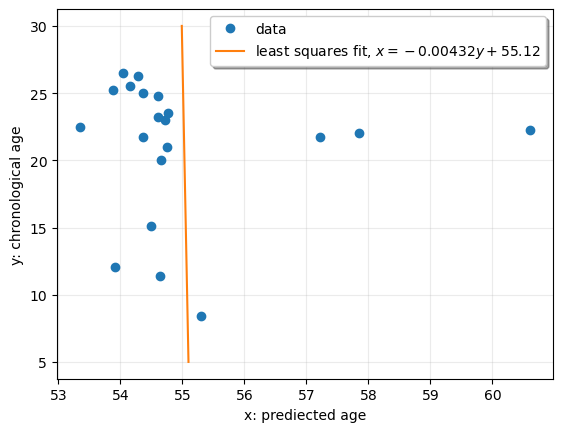

In [12]:
plt.plot(x, y, 'o', label='data')
yy = np.linspace(5, 30, 101)
xx = p[0] * yy + p[1]
plt.plot(xx, yy, label=f'least squares fit, $x = {p[0]:.5f}y + {p[1]:.2f}$')
plt.xlabel('x: prediected age')
plt.ylabel('y: chronological age')
plt.legend(framealpha=1, shadow=True)
plt.grid(alpha=0.25)
plt.show()

In [13]:
a = p[0]
b = p[1]
x_corrected = (x-b)/a
x_corrected

array([  191.88825389,    83.60350095,    93.94076695,    82.44355143,
         173.55597697,   224.95207583,   117.69088267,   172.9525557 ,
         108.95779501,   119.10208141,  -633.02383565,  -486.4499941 ,
         287.06326133,   411.55905588, -1271.70924177,   146.57664515,
         247.69025354,   -41.05437303,   112.65356001,   278.92872783])

In [12]:
from sklearn.linear_model import LinearRegression
import numpy as np
def bias_correction(y: np.ndarray, y_pred: np.ndarray):
    """
    :param y: chronological age (ground truth)
    :param y_pred: brain age before bias correction (predictions)
    :return: bias-corrected brain age
    """
    # Smith2019 bias correction
    linear_fit = LinearRegression(fit_intercept=True).fit(
        X=y, y=y_pred
    )
    intercept, slope = linear_fit.intercept_, linear_fit.coef_[0]
    y_pred_unbiased = (y_pred - intercept) / (slope + np.finfo(np.float32).eps) # avoid division by 0
    return y_pred_unbiased

In [16]:
x_corrected_2 = bias_correction(y=y.reshape(-1, 1), y_pred=x.reshape(-1, 1))
x_corrected_2

array([[  191.89355   ],
       [   83.60580841],
       [   93.94335971],
       [   82.44582687],
       [  173.56076711],
       [  224.9582845 ],
       [  117.69413093],
       [  172.95732919],
       [  108.96080224],
       [  119.10536862],
       [ -633.04130709],
       [ -486.4634201 ],
       [  287.07118427],
       [  411.5704149 ],
       [-1271.7443409 ],
       [  146.58069066],
       [  247.69708979],
       [  -41.05550613],
       [  112.65666924],
       [  278.93642625]])

In [48]:
# save the dataframe so that we can load it directly next time
#my_info_df4.to_pickle("./df_pred_data_small.pkl")
#my_info_df4 = pd.read_pickle("./df_pred_data_small.pkl")

In [40]:
#torch.cuda.memory_summary(device=None, abbreviated=False)